In [32]:
import torch
import numpy as np
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm
torch.cuda.is_available()

True

In [33]:
CVAP_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAP_SD/CVAP_all_SD.csv', encoding= 'utf-8',sep="\t")
df0 = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df0['class'] = 'Phrase'
#df0.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']

CVAS_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAS_SD/CVAS_all.csv', encoding= 'utf-8',sep="\t")
df1 = CVAS_all_SD_df.drop(['Valence_SD', 'Arousal_SD'], axis= 1)
df1['class'] = 'Text'
df1.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


CVAW_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAW_SD/CVAW_all_SD.csv', encoding= 'utf-8',sep="\t")
df2 = CVAW_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df2['class'] = 'Word'
df2.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


df = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df
# print(df0.loc[1])
# print(df1.loc[1])
# print(df2.loc[1])

,Phrase,Valence_Mean,Arousal_Mean
0,怪八卦,3.450,4.383
1,更加小心,5.111,7.188
2,格外小心,3.950,6.500
3,特別小心,5.000,7.000
4,極為小心,3.989,6.925
...,...,...,...
2245,沒有最爛,4.144,4.850
2246,沒很爛,4.643,4.878
2247,沒有最蠢,3.214,5.200
2248,沒太驚訝,4.963,5.975


In [34]:

# combined_df = pd.concat([df0, df1, df2], ignore_index=True)

# # 将'class'列转换为哑变量
# dummy_class = pd.get_dummies(combined_df['class'], prefix='class')

# # 将哑变量与原始数据帧合并
# combined_df = pd.concat([combined_df, dummy_class], axis=1)

# # 删除原始的'class'列
# combined_df = combined_df.drop('class', axis=1)
# df = combined_df
# df


In [35]:

# 提取特徵和標籤
#X = df[['Valence_Mean', 'Arousal_Mean']]
#y = df['Phrase'] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱
x = df['Phrase']
# y = df[['Valence_Mean','Arousal_Mean','class_Phrase','class_Text','class_Word']] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱
y = df[['Valence_Mean','Arousal_Mean']]
# 將數據集分成訓練集和測試集，以 80:20 的比例分割
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size= 0.8)
print(x_train)


478        蠻喜歡
1247       超不愛
2100    沒有非常強烈
629         越慢
1040     完全不信任
         ...  
1638     本來超開心
1095      最沒效率
1130      非常不爽
1294     極度不樂觀
860       異常嚴格
Name: Phrase, Length: 1800, dtype: object


In [36]:
bert = AutoModel.from_pretrained('bert-base-chinese', return_dict=False)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

# from transformers import (
#   BertTokenizerFast,
#   AutoModel,
# )

# tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
# bert = AutoModel.from_pretrained('ckiplab/bert-base-chinese', return_dict=False)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
train_idx = x_train.dropna().index
test_idx = x_test.dropna().index

train_tokens = tokenizer.batch_encode_plus(x_train[train_idx].to_list(),
                                           max_length = 50,
                                           #pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
test_tokens = tokenizer.batch_encode_plus(x_test[test_idx].to_list(),
                                           max_length = 50,
                                          # pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
#print(y_train['Valence_Mean'])
# y_train = y_train.reset_index(drop = True)
#y_train.loc[0]

In [38]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
# print([i for i in y_train['Valence_Mean']])
# train_y = torch.tensor([i for i in y_train['Valence_Mean']])
train_y = torch.tensor([(i, j) for i, j in zip(y_train['Valence_Mean'], y_train['Arousal_Mean'])])
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
#test_y = torch.tensor([i for i in y_test['Valence_Mean']])
test_y = torch.tensor([(i, j) for i, j in zip(y_test['Valence_Mean'], y_test['Arousal_Mean'])])

In [39]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

In [40]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, 
                         sampler = train_sampler,
                         batch_size = 32)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_data)
testloader = DataLoader(test_data, 
                         sampler = test_sampler,
                         batch_size = 32)

In [41]:
for param in bert.parameters():
    param.requires_grad = False

In [42]:
from torch import nn
from transformers import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [43]:
# class BertRegressor(nn.Module):
#     def __init__(self, bert):
#         super().__init__()
#         self.bert = bert
#         self.fc1 = nn.Linear(768, 1)  # output one continuous value
    
#     def forward(self, sent_id, mask):
#         _, cls_hs = self.bert(sent_id, attention_mask=mask)
#         return self.fc1(cls_hs).squeeze()  # remove the last dimension of size 1
    
class BertRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.fc1 = nn.Linear(768, 128)  # add a linear layer with output size 128
        self.relu = nn.ReLU()  # add ReLU activation function
        self.fc2 = nn.Linear(128, 128)  # output one continuous value
        self.fc3 = nn.Linear(128, 2)  # output one continuous value

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)  # apply ReLU activation
        x = self.fc2(x)
        x = self.relu(x)  # apply ReLU activation
        # return self.fc3(x).squeeze()  # remove the last dimension of size 1
        return self.fc3(x)


In [44]:
model = BertRegressor(bert)
model = model.cuda()

In [45]:
optimizer = AdamW(model.parameters(), lr=1e-5)

c:\Program Files\Python\38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [46]:
# def loss_fn(outputs, targets):
#     return F.mse_loss(outputs, targets)

In [47]:
#criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='sum')
criterion = torch.nn.SmoothL1Loss(reduction='mean')

In [48]:
from tqdm import tqdm
# def early_stopping(train_loss, validation_loss, min_delta, tolerance):

#     counter = 0
#     if (validation_loss - train_loss) > min_delta:
#         counter +=1
#         if counter >= tolerance:
#           return True

In [49]:
epochs = 1000
losses = []
for e in range(epochs):   
    train_loss = 0.0
    for batch in tqdm(trainloader):
        batch = [i.cuda() for i in batch]
        sent_id, masks, labels = batch

        optimizer.zero_grad()
        preds = model(sent_id, masks)
        loss = criterion(preds, labels)
        train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    losses.append(train_loss / len(trainloader))
    # if early_stopping(epoch_train_loss, epoch_validate_loss, min_delta=10, tolerance = 20):
    #   print("We are at epoch:", i)
    #   break
    print(f'Epoch:{e+1}\t\tTraining Loss: {train_loss / len(trainloader)}')

100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:1		Training Loss: 4.4680715443795185


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:2		Training Loss: 4.105418715560646


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:3		Training Loss: 3.6581931867097555


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:4		Training Loss: 3.144725987785741


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:5		Training Loss: 2.5968138836977777


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:6		Training Loss: 2.0099494248105767


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:7		Training Loss: 1.4527835825033355


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:8		Training Loss: 0.9995852159826379


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:9		Training Loss: 0.8317844637653284


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:10		Training Loss: 0.815188655727788


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:11		Training Loss: 0.8144372743472719


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:12		Training Loss: 0.8123355246426767


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:13		Training Loss: 0.8027476344192237


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:14		Training Loss: 0.8056744964499223


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:15		Training Loss: 0.8031697273254395


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:16		Training Loss: 0.7983023973933437


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:17		Training Loss: 0.7972259688795659


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:18		Training Loss: 0.8018367227755094


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:19		Training Loss: 0.7851211972403944


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:20		Training Loss: 0.7861981506933245


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:21		Training Loss: 0.7905054406115883


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:22		Training Loss: 0.7848581253436574


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:23		Training Loss: 0.780072620040492


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:24		Training Loss: 0.7778018462030512


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:25		Training Loss: 0.7757814327875773


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:26		Training Loss: 0.7723352041160851


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:27		Training Loss: 0.7701502923379865


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:28		Training Loss: 0.766419242871435


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:29		Training Loss: 0.7636569309652897


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:30		Training Loss: 0.7662510328125536


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:31		Training Loss: 0.7577332728787473


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:32		Training Loss: 0.7568693150553787


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:33		Training Loss: 0.7505836005796466


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:34		Training Loss: 0.7550993206208212


100%|██████████| 57/57 [00:00<00:00, 64.55it/s]


Epoch:35		Training Loss: 0.7466050072720176


100%|██████████| 57/57 [00:00<00:00, 64.63it/s]


Epoch:36		Training Loss: 0.7470661935053373


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:37		Training Loss: 0.7434059621994955


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:38		Training Loss: 0.7453557284254777


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:39		Training Loss: 0.7376969895864788


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:40		Training Loss: 0.7383890622540524


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:41		Training Loss: 0.7366269304041277


100%|██████████| 57/57 [00:00<00:00, 61.42it/s]


Epoch:42		Training Loss: 0.7293019137884441


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:43		Training Loss: 0.7326149626782066


100%|██████████| 57/57 [00:00<00:00, 61.55it/s]


Epoch:44		Training Loss: 0.7290912814307631


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:45		Training Loss: 0.7247940030014306


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:46		Training Loss: 0.7222213818315875


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:47		Training Loss: 0.7236262622632479


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:48		Training Loss: 0.7201001048088074


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:49		Training Loss: 0.7145070313361653


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:50		Training Loss: 0.7065150157401436


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:51		Training Loss: 0.706756022415663


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:52		Training Loss: 0.7052761891431976


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:53		Training Loss: 0.7013789844094661


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:54		Training Loss: 0.700869352671138


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:55		Training Loss: 0.7031083682127166


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:56		Training Loss: 0.6959904819204096


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:57		Training Loss: 0.6958748808032588


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:58		Training Loss: 0.692135258724815


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:59		Training Loss: 0.6862750597167433


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:60		Training Loss: 0.6808110120003683


100%|██████████| 57/57 [00:00<00:00, 61.16it/s]


Epoch:61		Training Loss: 0.6853467508366233


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:62		Training Loss: 0.6780654652076855


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:63		Training Loss: 0.6788126742630675


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:64		Training Loss: 0.6776775963473738


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:65		Training Loss: 0.6675641139348348


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:66		Training Loss: 0.6647675643887436


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:67		Training Loss: 0.6603390893392396


100%|██████████| 57/57 [00:00<00:00, 60.90it/s]


Epoch:68		Training Loss: 0.6622424585777417


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:69		Training Loss: 0.6610943094680184


100%|██████████| 57/57 [00:00<00:00, 62.35it/s]


Epoch:70		Training Loss: 0.6571801294360244


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:71		Training Loss: 0.6499835054079691


100%|██████████| 57/57 [00:00<00:00, 60.50it/s]


Epoch:72		Training Loss: 0.6505245325858133


100%|██████████| 57/57 [00:00<00:00, 59.69it/s]


Epoch:73		Training Loss: 0.6485823063473952


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:74		Training Loss: 0.6449762865116722


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:75		Training Loss: 0.6386516580456182


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:76		Training Loss: 0.6443634493309155


100%|██████████| 57/57 [00:00<00:00, 61.96it/s]


Epoch:77		Training Loss: 0.6392573243693301


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:78		Training Loss: 0.6332452605690873


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:79		Training Loss: 0.6325393821063795


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:80		Training Loss: 0.6302067135509691


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:81		Training Loss: 0.6266507051492992


100%|██████████| 57/57 [00:00<00:00, 62.23it/s]


Epoch:82		Training Loss: 0.6232083131346786


100%|██████████| 57/57 [00:00<00:00, 60.57it/s]


Epoch:83		Training Loss: 0.6238029965183192


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:84		Training Loss: 0.6241482391692045


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:85		Training Loss: 0.6202331425850851


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:86		Training Loss: 0.6163025027827213


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:87		Training Loss: 0.6148558588404405


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:88		Training Loss: 0.6113742589950562


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:89		Training Loss: 0.611757111653947


100%|██████████| 57/57 [00:00<00:00, 61.49it/s]


Epoch:90		Training Loss: 0.6113397552255999


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:91		Training Loss: 0.6026779371395445


100%|██████████| 57/57 [00:00<00:00, 60.96it/s]


Epoch:92		Training Loss: 0.6067417206471426


100%|██████████| 57/57 [00:00<00:00, 61.32it/s]


Epoch:93		Training Loss: 0.6015458875580838


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:94		Training Loss: 0.5958485080484759


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:95		Training Loss: 0.6023634473482767


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:96		Training Loss: 0.5961208599701262


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:97		Training Loss: 0.5935377844592982


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:98		Training Loss: 0.5926742009949266


100%|██████████| 57/57 [00:00<00:00, 61.69it/s]


Epoch:99		Training Loss: 0.5890460103227381


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:100		Training Loss: 0.5874797806405184


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:101		Training Loss: 0.5873563833404005


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:102		Training Loss: 0.589308454279314


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:103		Training Loss: 0.586250756916247


100%|██████████| 57/57 [00:00<00:00, 61.69it/s]


Epoch:104		Training Loss: 0.5823646464891601


100%|██████████| 57/57 [00:00<00:00, 61.36it/s]


Epoch:105		Training Loss: 0.5788066413318902


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:106		Training Loss: 0.5791363653383756


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:107		Training Loss: 0.5752347948258383


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:108		Training Loss: 0.573486288911418


100%|██████████| 57/57 [00:00<00:00, 60.77it/s]


Epoch:109		Training Loss: 0.5762949240835089


100%|██████████| 57/57 [00:00<00:00, 60.32it/s]


Epoch:110		Training Loss: 0.5735296068484323


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:111		Training Loss: 0.5672846044364729


100%|██████████| 57/57 [00:00<00:00, 60.51it/s]


Epoch:112		Training Loss: 0.5691868124300974


100%|██████████| 57/57 [00:00<00:00, 61.96it/s]


Epoch:113		Training Loss: 0.5707419242775231


100%|██████████| 57/57 [00:00<00:00, 60.38it/s]


Epoch:114		Training Loss: 0.5708395624369905


100%|██████████| 57/57 [00:00<00:00, 60.06it/s]


Epoch:115		Training Loss: 0.5629574954509735


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:116		Training Loss: 0.5608411483597338


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:117		Training Loss: 0.5615367476354566


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:118		Training Loss: 0.5601864143421775


100%|██████████| 57/57 [00:00<00:00, 61.89it/s]


Epoch:119		Training Loss: 0.5556808866952595


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:120		Training Loss: 0.560709641167992


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:121		Training Loss: 0.5550763146919117


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:122		Training Loss: 0.5557728357482374


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:123		Training Loss: 0.5515704693501455


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:124		Training Loss: 0.5564593186503962


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:125		Training Loss: 0.550108416038647


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:126		Training Loss: 0.5510157644748688


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:127		Training Loss: 0.5533330487577539


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:128		Training Loss: 0.5434452776323285


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:129		Training Loss: 0.5487771734856722


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:130		Training Loss: 0.543910974473284


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:131		Training Loss: 0.5454161245571939


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:132		Training Loss: 0.5470142082164162


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:133		Training Loss: 0.5408675979103958


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:134		Training Loss: 0.5392109929469594


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:135		Training Loss: 0.5370364466257262


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:136		Training Loss: 0.5389925262384248


100%|██████████| 57/57 [00:00<00:00, 61.29it/s]


Epoch:137		Training Loss: 0.5348649924261528


100%|██████████| 57/57 [00:00<00:00, 60.81it/s]


Epoch:138		Training Loss: 0.5392969266364449


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:139		Training Loss: 0.5355217320877209


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:140		Training Loss: 0.5369162549052322


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:141		Training Loss: 0.5324193014387499


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:142		Training Loss: 0.5314238594289411


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:143		Training Loss: 0.5320818235999659


100%|██████████| 57/57 [00:00<00:00, 61.42it/s]


Epoch:144		Training Loss: 0.534655106172227


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:145		Training Loss: 0.5313830271101835


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:146		Training Loss: 0.5313741575207627


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:147		Training Loss: 0.5291521559681809


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:148		Training Loss: 0.529463516515598


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:149		Training Loss: 0.5295976102352142


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:150		Training Loss: 0.5262775332258459


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:151		Training Loss: 0.5245506465435028


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:152		Training Loss: 0.5252351781778168


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:153		Training Loss: 0.520360960772163


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:154		Training Loss: 0.5249759309124529


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:155		Training Loss: 0.5187585186540035


100%|██████████| 57/57 [00:00<00:00, 61.42it/s]


Epoch:156		Training Loss: 0.5196148047321721


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:157		Training Loss: 0.5179752137577325


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:158		Training Loss: 0.5169417533958167


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:159		Training Loss: 0.5198651761339422


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:160		Training Loss: 0.5154003626421878


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:161		Training Loss: 0.514375414764672


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:162		Training Loss: 0.5144475996494293


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:163		Training Loss: 0.5133260326427326


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:164		Training Loss: 0.5150381985463595


100%|██████████| 57/57 [00:00<00:00, 61.29it/s]


Epoch:165		Training Loss: 0.5102052568343648


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:166		Training Loss: 0.5182102197094968


100%|██████████| 57/57 [00:00<00:00, 62.09it/s]


Epoch:167		Training Loss: 0.5085863816110712


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:168		Training Loss: 0.5069337842757242


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:169		Training Loss: 0.5075724522272745


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:170		Training Loss: 0.5055791960473646


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:171		Training Loss: 0.5097056156710574


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:172		Training Loss: 0.5071295295891008


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:173		Training Loss: 0.5066911191271063


100%|██████████| 57/57 [00:00<00:00, 60.19it/s]


Epoch:174		Training Loss: 0.5057372910934582


100%|██████████| 57/57 [00:00<00:00, 60.83it/s]


Epoch:175		Training Loss: 0.5030362830873121


100%|██████████| 57/57 [00:00<00:00, 62.33it/s]


Epoch:176		Training Loss: 0.5041792387502235


100%|██████████| 57/57 [00:00<00:00, 61.09it/s]


Epoch:177		Training Loss: 0.5044130672488296


100%|██████████| 57/57 [00:00<00:00, 61.29it/s]


Epoch:178		Training Loss: 0.5029037605252182


100%|██████████| 57/57 [00:00<00:00, 61.69it/s]


Epoch:179		Training Loss: 0.4999079343519713


100%|██████████| 57/57 [00:00<00:00, 62.68it/s]


Epoch:180		Training Loss: 0.49756972570168345


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:181		Training Loss: 0.4997542573694597


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:182		Training Loss: 0.5022572315575784


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:183		Training Loss: 0.4987036941344278


100%|██████████| 57/57 [00:00<00:00, 62.81it/s]


Epoch:184		Training Loss: 0.4934743642807007


100%|██████████| 57/57 [00:00<00:00, 61.49it/s]


Epoch:185		Training Loss: 0.4986471397834912


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:186		Training Loss: 0.4940539222014578


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:187		Training Loss: 0.49436877066628976


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:188		Training Loss: 0.4976364698326379


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:189		Training Loss: 0.49379837617539524


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:190		Training Loss: 0.491785617773993


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:191		Training Loss: 0.48843395709991455


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:192		Training Loss: 0.4911313469995532


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:193		Training Loss: 0.4910583020302287


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:194		Training Loss: 0.48890176886006403


100%|██████████| 57/57 [00:00<00:00, 62.40it/s]


Epoch:195		Training Loss: 0.49204795977525545


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:196		Training Loss: 0.4887333533220124


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:197		Training Loss: 0.4836316140074479


100%|██████████| 57/57 [00:00<00:00, 63.02it/s]


Epoch:198		Training Loss: 0.4862711826960246


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:199		Training Loss: 0.48457814413204525


100%|██████████| 57/57 [00:00<00:00, 62.74it/s]


Epoch:200		Training Loss: 0.4824308036712178


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:201		Training Loss: 0.48484843603351657


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:202		Training Loss: 0.4811054269472758


100%|██████████| 57/57 [00:00<00:00, 62.90it/s]


Epoch:203		Training Loss: 0.4822699119124496


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:204		Training Loss: 0.4837791522343953


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:205		Training Loss: 0.48025793987408016


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:206		Training Loss: 0.4785461441466683


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:207		Training Loss: 0.48158407159018934


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:208		Training Loss: 0.4770102019895587


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:209		Training Loss: 0.48056208930517497


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:210		Training Loss: 0.4768075320804328


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:211		Training Loss: 0.47604592222916453


100%|██████████| 57/57 [00:00<00:00, 61.09it/s]


Epoch:212		Training Loss: 0.47787995662605554


100%|██████████| 57/57 [00:00<00:00, 62.53it/s]


Epoch:213		Training Loss: 0.47695800714325487


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:214		Training Loss: 0.4726074149734096


100%|██████████| 57/57 [00:00<00:00, 62.63it/s]


Epoch:215		Training Loss: 0.4755771730029792


100%|██████████| 57/57 [00:00<00:00, 63.16it/s]


Epoch:216		Training Loss: 0.47335495028579444


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:217		Training Loss: 0.4700053200909966


100%|██████████| 57/57 [00:00<00:00, 61.29it/s]


Epoch:218		Training Loss: 0.47281743873629656


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:219		Training Loss: 0.472454801986092


100%|██████████| 57/57 [00:00<00:00, 59.62it/s]


Epoch:220		Training Loss: 0.47859165020156325


100%|██████████| 57/57 [00:00<00:00, 59.53it/s]


Epoch:221		Training Loss: 0.4709380734385106


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:222		Training Loss: 0.46993410953304227


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:223		Training Loss: 0.47404074041466965


100%|██████████| 57/57 [00:00<00:00, 60.75it/s]


Epoch:224		Training Loss: 0.4672108146182278


100%|██████████| 57/57 [00:00<00:00, 62.33it/s]


Epoch:225		Training Loss: 0.46995089503756743


100%|██████████| 57/57 [00:00<00:00, 62.53it/s]


Epoch:226		Training Loss: 0.46750888176131666


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:227		Training Loss: 0.46501601422042177


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:228		Training Loss: 0.4688211663773185


100%|██████████| 57/57 [00:00<00:00, 62.94it/s]


Epoch:229		Training Loss: 0.46955854537194236


100%|██████████| 57/57 [00:00<00:00, 60.13it/s]


Epoch:230		Training Loss: 0.4641206128555432


100%|██████████| 57/57 [00:00<00:00, 60.16it/s]


Epoch:231		Training Loss: 0.46121921873929206


100%|██████████| 57/57 [00:00<00:00, 61.89it/s]


Epoch:232		Training Loss: 0.46392788960222614


100%|██████████| 57/57 [00:00<00:00, 60.13it/s]


Epoch:233		Training Loss: 0.4653032720088959


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:234		Training Loss: 0.4659975469112396


100%|██████████| 57/57 [00:00<00:00, 62.99it/s]


Epoch:235		Training Loss: 0.46422729523558365


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:236		Training Loss: 0.45806258446291875


100%|██████████| 57/57 [00:00<00:00, 61.96it/s]


Epoch:237		Training Loss: 0.46110967951908444


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:238		Training Loss: 0.4580382048560862


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:239		Training Loss: 0.4608962148950811


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:240		Training Loss: 0.4607917755319361


100%|██████████| 57/57 [00:00<00:00, 61.76it/s]


Epoch:241		Training Loss: 0.4604026084406334


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:242		Training Loss: 0.46193859399410714


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:243		Training Loss: 0.46067527145670173


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:244		Training Loss: 0.45620648170772354


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:245		Training Loss: 0.45791183699641314


100%|██████████| 57/57 [00:00<00:00, 61.87it/s]


Epoch:246		Training Loss: 0.4625954936470902


100%|██████████| 57/57 [00:00<00:00, 62.67it/s]


Epoch:247		Training Loss: 0.455914916176545


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:248		Training Loss: 0.45303307499801904


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:249		Training Loss: 0.4572062497599083


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:250		Training Loss: 0.4513055020779894


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:251		Training Loss: 0.45536787990938155


100%|██████████| 57/57 [00:00<00:00, 62.29it/s]


Epoch:252		Training Loss: 0.452899133949949


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:253		Training Loss: 0.4548978993767186


100%|██████████| 57/57 [00:00<00:00, 62.47it/s]


Epoch:254		Training Loss: 0.4535982582652778


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:255		Training Loss: 0.44804561033583523


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:256		Training Loss: 0.4525845484775409


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:257		Training Loss: 0.45331671520283345


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:258		Training Loss: 0.44922334008049547


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:259		Training Loss: 0.4478700699513419


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:260		Training Loss: 0.45246339837710065


100%|██████████| 57/57 [00:00<00:00, 61.76it/s]


Epoch:261		Training Loss: 0.45140494432365685


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:262		Training Loss: 0.4495741583799061


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:263		Training Loss: 0.4505357585455242


100%|██████████| 57/57 [00:00<00:00, 63.32it/s]


Epoch:264		Training Loss: 0.44527413447697956


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:265		Training Loss: 0.44742337444372343


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:266		Training Loss: 0.4448935630028708


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:267		Training Loss: 0.4482174798061973


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:268		Training Loss: 0.44586471977986786


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:269		Training Loss: 0.44520538156492667


100%|██████████| 57/57 [00:00<00:00, 63.16it/s]


Epoch:270		Training Loss: 0.44479875240409583


100%|██████████| 57/57 [00:00<00:00, 63.65it/s]


Epoch:271		Training Loss: 0.4422643796393746


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:272		Training Loss: 0.4425273046158908


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:273		Training Loss: 0.44052024420938996


100%|██████████| 57/57 [00:00<00:00, 63.65it/s]


Epoch:274		Training Loss: 0.4424664012172766


100%|██████████| 57/57 [00:00<00:00, 64.01it/s]


Epoch:275		Training Loss: 0.44071531714054574


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:276		Training Loss: 0.4414800719210976


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:277		Training Loss: 0.44136711693646613


100%|██████████| 57/57 [00:00<00:00, 63.67it/s]


Epoch:278		Training Loss: 0.44080158126981633


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:279		Training Loss: 0.44011266085139494


100%|██████████| 57/57 [00:00<00:00, 63.39it/s]


Epoch:280		Training Loss: 0.44316949394711275


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:281		Training Loss: 0.44445939179052385


100%|██████████| 57/57 [00:00<00:00, 63.44it/s]


Epoch:282		Training Loss: 0.4467561647557376


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:283		Training Loss: 0.4384729707973045


100%|██████████| 57/57 [00:00<00:00, 62.06it/s]


Epoch:284		Training Loss: 0.4385410881879037


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:285		Training Loss: 0.44227706863169086


100%|██████████| 57/57 [00:00<00:00, 61.89it/s]


Epoch:286		Training Loss: 0.4411975537475787


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:287		Training Loss: 0.4408697140844245


100%|██████████| 57/57 [00:00<00:00, 61.59it/s]


Epoch:288		Training Loss: 0.4355766151035041


100%|██████████| 57/57 [00:00<00:00, 62.40it/s]


Epoch:289		Training Loss: 0.43609921608054847


100%|██████████| 57/57 [00:00<00:00, 62.19it/s]


Epoch:290		Training Loss: 0.4349758008070159


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:291		Training Loss: 0.4360439735546447


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:292		Training Loss: 0.4340429096891169


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:293		Training Loss: 0.4347582260767619


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:294		Training Loss: 0.4332613307133056


100%|██████████| 57/57 [00:00<00:00, 62.97it/s]


Epoch:295		Training Loss: 0.43376825880586056


100%|██████████| 57/57 [00:00<00:00, 63.30it/s]


Epoch:296		Training Loss: 0.437910703190586


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:297		Training Loss: 0.4311950826331189


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:298		Training Loss: 0.4360510011514028


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:299		Training Loss: 0.4325810527069527


100%|██████████| 57/57 [00:00<00:00, 63.23it/s]


Epoch:300		Training Loss: 0.4300263231260735


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:301		Training Loss: 0.43162249368533756


100%|██████████| 57/57 [00:00<00:00, 63.94it/s]


Epoch:302		Training Loss: 0.4296427139064722


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:303		Training Loss: 0.436748616005245


100%|██████████| 57/57 [00:00<00:00, 61.49it/s]


Epoch:304		Training Loss: 0.43196947166794225


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:305		Training Loss: 0.43290087319256965


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:306		Training Loss: 0.43295608382476003


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:307		Training Loss: 0.4288842887209173


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:308		Training Loss: 0.4307055776579338


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:309		Training Loss: 0.4290271014497991


100%|██████████| 57/57 [00:00<00:00, 63.44it/s]


Epoch:310		Training Loss: 0.4279964038154535


100%|██████████| 57/57 [00:00<00:00, 63.54it/s]


Epoch:311		Training Loss: 0.4294258627975196


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:312		Training Loss: 0.42622436034051997


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:313		Training Loss: 0.428680956363678


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:314		Training Loss: 0.4264711648748632


100%|██████████| 57/57 [00:00<00:00, 61.03it/s]


Epoch:315		Training Loss: 0.42542424432018344


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:316		Training Loss: 0.42648436991791977


100%|██████████| 57/57 [00:00<00:00, 63.44it/s]


Epoch:317		Training Loss: 0.42423142545055925


100%|██████████| 57/57 [00:00<00:00, 61.26it/s]


Epoch:318		Training Loss: 0.43046228404630693


100%|██████████| 57/57 [00:00<00:00, 60.51it/s]


Epoch:319		Training Loss: 0.4264924434716241


100%|██████████| 57/57 [00:00<00:00, 60.83it/s]


Epoch:320		Training Loss: 0.42473026534967256


100%|██████████| 57/57 [00:00<00:00, 59.94it/s]


Epoch:321		Training Loss: 0.42864383051269933


100%|██████████| 57/57 [00:00<00:00, 60.51it/s]


Epoch:322		Training Loss: 0.42169932001515437


100%|██████████| 57/57 [00:00<00:00, 59.07it/s]


Epoch:323		Training Loss: 0.42111598321220334


100%|██████████| 57/57 [00:00<00:00, 58.55it/s]


Epoch:324		Training Loss: 0.4225815691446003


100%|██████████| 57/57 [00:00<00:00, 60.39it/s]


Epoch:325		Training Loss: 0.42541663845380145


100%|██████████| 57/57 [00:00<00:00, 59.25it/s]


Epoch:326		Training Loss: 0.4244899524931322


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:327		Training Loss: 0.4225367746855083


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:328		Training Loss: 0.4203574829979947


100%|██████████| 57/57 [00:00<00:00, 60.96it/s]


Epoch:329		Training Loss: 0.4250683711286177


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:330		Training Loss: 0.42201761979805796


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:331		Training Loss: 0.4207549351349212


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:332		Training Loss: 0.4213530165061616


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:333		Training Loss: 0.42097233314263194


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:334		Training Loss: 0.421173658287316


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:335		Training Loss: 0.4192895340292077


100%|██████████| 57/57 [00:00<00:00, 61.35it/s]


Epoch:336		Training Loss: 0.4185173861813127


100%|██████████| 57/57 [00:00<00:00, 61.03it/s]


Epoch:337		Training Loss: 0.41955875932124626


100%|██████████| 57/57 [00:00<00:00, 61.28it/s]


Epoch:338		Training Loss: 0.4173782577640132


100%|██████████| 57/57 [00:00<00:00, 61.03it/s]


Epoch:339		Training Loss: 0.416568435597838


100%|██████████| 57/57 [00:00<00:00, 61.76it/s]


Epoch:340		Training Loss: 0.41723558568117913


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:341		Training Loss: 0.4186539106201707


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:342		Training Loss: 0.42309845042856115


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:343		Training Loss: 0.41953776959787337


100%|██████████| 57/57 [00:00<00:00, 63.10it/s]


Epoch:344		Training Loss: 0.42565215261358963


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:345		Training Loss: 0.41856608526748523


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:346		Training Loss: 0.419942238351755


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:347		Training Loss: 0.41791717106835885


100%|██████████| 57/57 [00:00<00:00, 61.42it/s]


Epoch:348		Training Loss: 0.41686402757962543


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:349		Training Loss: 0.41512709856033325


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:350		Training Loss: 0.41915235393925715


100%|██████████| 57/57 [00:00<00:00, 61.42it/s]


Epoch:351		Training Loss: 0.4167811499353041


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:352		Training Loss: 0.41434891495788306


100%|██████████| 57/57 [00:00<00:00, 60.77it/s]


Epoch:353		Training Loss: 0.4139577469281983


100%|██████████| 57/57 [00:00<00:00, 61.20it/s]


Epoch:354		Training Loss: 0.41425792480769913


100%|██████████| 57/57 [00:00<00:00, 60.06it/s]


Epoch:355		Training Loss: 0.4152529386051914


100%|██████████| 57/57 [00:00<00:00, 61.89it/s]


Epoch:356		Training Loss: 0.41231605959566014


100%|██████████| 57/57 [00:00<00:00, 60.83it/s]


Epoch:357		Training Loss: 0.41687740934522527


100%|██████████| 57/57 [00:00<00:00, 62.26it/s]


Epoch:358		Training Loss: 0.41373717706454427


100%|██████████| 57/57 [00:00<00:00, 61.99it/s]


Epoch:359		Training Loss: 0.4106774774559757


100%|██████████| 57/57 [00:00<00:00, 62.23it/s]


Epoch:360		Training Loss: 0.40958903756058007


100%|██████████| 57/57 [00:00<00:00, 60.90it/s]


Epoch:361		Training Loss: 0.4175655653602199


100%|██████████| 57/57 [00:00<00:00, 60.57it/s]


Epoch:362		Training Loss: 0.4168071208292978


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:363		Training Loss: 0.4109501592945634


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:364		Training Loss: 0.4157657440294299


100%|██████████| 57/57 [00:00<00:00, 62.25it/s]


Epoch:365		Training Loss: 0.4150773861951995


100%|██████████| 57/57 [00:00<00:00, 61.39it/s]


Epoch:366		Training Loss: 0.41242464958575736


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:367		Training Loss: 0.4089187158827196


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:368		Training Loss: 0.40767321173559157


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:369		Training Loss: 0.4080825463721627


100%|██████████| 57/57 [00:00<00:00, 61.72it/s]


Epoch:370		Training Loss: 0.41153111740162496


100%|██████████| 57/57 [00:00<00:00, 61.36it/s]


Epoch:371		Training Loss: 0.40660972448817473


100%|██████████| 57/57 [00:00<00:00, 60.77it/s]


Epoch:372		Training Loss: 0.4080653781430763


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:373		Training Loss: 0.40715457943447847


100%|██████████| 57/57 [00:00<00:00, 62.26it/s]


Epoch:374		Training Loss: 0.40716357189312313


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:375		Training Loss: 0.40502533473466573


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:376		Training Loss: 0.40901090230858117


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:377		Training Loss: 0.40697889735824183


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:378		Training Loss: 0.40472190055930823


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:379		Training Loss: 0.4059251201780219


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:380		Training Loss: 0.40310853719711304


100%|██████████| 57/57 [00:00<00:00, 61.55it/s]


Epoch:381		Training Loss: 0.4055187357099433


100%|██████████| 57/57 [00:00<00:00, 60.00it/s]


Epoch:382		Training Loss: 0.40395218865913257


100%|██████████| 57/57 [00:00<00:00, 59.31it/s]


Epoch:383		Training Loss: 0.4063820488620223


100%|██████████| 57/57 [00:00<00:00, 62.12it/s]


Epoch:384		Training Loss: 0.40697986410375225


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:385		Training Loss: 0.4032257502539116


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:386		Training Loss: 0.4050928777769992


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:387		Training Loss: 0.4019278057834558


100%|██████████| 57/57 [00:00<00:00, 59.60it/s]


Epoch:388		Training Loss: 0.4020293517070904


100%|██████████| 57/57 [00:00<00:00, 60.89it/s]


Epoch:389		Training Loss: 0.40497539649929915


100%|██████████| 57/57 [00:00<00:00, 61.03it/s]


Epoch:390		Training Loss: 0.4050176441669464


100%|██████████| 57/57 [00:00<00:00, 61.09it/s]


Epoch:391		Training Loss: 0.402111491090373


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:392		Training Loss: 0.4015782454557586


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:393		Training Loss: 0.3988005453557299


100%|██████████| 57/57 [00:00<00:00, 61.76it/s]


Epoch:394		Training Loss: 0.4061843888801441


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:395		Training Loss: 0.40389080633196917


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:396		Training Loss: 0.4028992114359872


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:397		Training Loss: 0.40028521078720425


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:398		Training Loss: 0.4026867015319958


100%|██████████| 57/57 [00:00<00:00, 57.81it/s]


Epoch:399		Training Loss: 0.3989444576334535


100%|██████████| 57/57 [00:00<00:00, 60.86it/s]


Epoch:400		Training Loss: 0.40046415360350357


100%|██████████| 57/57 [00:00<00:00, 60.90it/s]


Epoch:401		Training Loss: 0.3975594428024794


100%|██████████| 57/57 [00:00<00:00, 60.42it/s]


Epoch:402		Training Loss: 0.4028826507559994


100%|██████████| 57/57 [00:00<00:00, 62.77it/s]


Epoch:403		Training Loss: 0.401533511385583


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:404		Training Loss: 0.39879805163333293


100%|██████████| 57/57 [00:00<00:00, 60.45it/s]


Epoch:405		Training Loss: 0.3978477036743833


100%|██████████| 57/57 [00:00<00:00, 61.46it/s]


Epoch:406		Training Loss: 0.39706162297934816


100%|██████████| 57/57 [00:00<00:00, 60.22it/s]


Epoch:407		Training Loss: 0.39990869216751634


100%|██████████| 57/57 [00:00<00:00, 59.07it/s]


Epoch:408		Training Loss: 0.40050181798767626


100%|██████████| 57/57 [00:00<00:00, 61.39it/s]


Epoch:409		Training Loss: 0.39531207319937256


100%|██████████| 57/57 [00:00<00:00, 60.13it/s]


Epoch:410		Training Loss: 0.39825383351560223


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:411		Training Loss: 0.39749749083268016


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:412		Training Loss: 0.4008953817058028


100%|██████████| 57/57 [00:00<00:00, 62.49it/s]


Epoch:413		Training Loss: 0.39848815349110384


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:414		Training Loss: 0.3991881739674953


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:415		Training Loss: 0.40069735050201416


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:416		Training Loss: 0.3926769910674346


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:417		Training Loss: 0.3934803280914039


100%|██████████| 57/57 [00:00<00:00, 61.36it/s]


Epoch:418		Training Loss: 0.3962995441336381


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:419		Training Loss: 0.39317368598360763


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:420		Training Loss: 0.3963360906692973


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:421		Training Loss: 0.3959527073199289


100%|██████████| 57/57 [00:00<00:00, 61.45it/s]


Epoch:422		Training Loss: 0.3965866680730853


100%|██████████| 57/57 [00:00<00:00, 60.70it/s]


Epoch:423		Training Loss: 0.3940461623041253


100%|██████████| 57/57 [00:00<00:00, 63.45it/s]


Epoch:424		Training Loss: 0.39473138462033186


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:425		Training Loss: 0.3954749400155586


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:426		Training Loss: 0.39160222285672236


100%|██████████| 57/57 [00:00<00:00, 62.23it/s]


Epoch:427		Training Loss: 0.39364075137857807


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:428		Training Loss: 0.39318050365698964


100%|██████████| 57/57 [00:00<00:00, 61.49it/s]


Epoch:429		Training Loss: 0.39401021390630486


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:430		Training Loss: 0.3904550812746349


100%|██████████| 57/57 [00:00<00:00, 62.47it/s]


Epoch:431		Training Loss: 0.3925078317784427


100%|██████████| 57/57 [00:00<00:00, 61.49it/s]


Epoch:432		Training Loss: 0.392369537499913


100%|██████████| 57/57 [00:00<00:00, 59.62it/s]


Epoch:433		Training Loss: 0.3985995948314667


100%|██████████| 57/57 [00:00<00:00, 61.03it/s]


Epoch:434		Training Loss: 0.3899731060914826


100%|██████████| 57/57 [00:00<00:00, 61.36it/s]


Epoch:435		Training Loss: 0.3897759956226014


100%|██████████| 57/57 [00:00<00:00, 63.09it/s]


Epoch:436		Training Loss: 0.3906243318005612


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:437		Training Loss: 0.38987721372068973


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:438		Training Loss: 0.3870889209864432


100%|██████████| 57/57 [00:00<00:00, 60.96it/s]


Epoch:439		Training Loss: 0.38905349060108785


100%|██████████| 57/57 [00:00<00:00, 58.75it/s]


Epoch:440		Training Loss: 0.3902055184569275


100%|██████████| 57/57 [00:00<00:00, 61.89it/s]


Epoch:441		Training Loss: 0.3864201359581529


100%|██████████| 57/57 [00:00<00:00, 61.79it/s]


Epoch:442		Training Loss: 0.39147758117893283


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:443		Training Loss: 0.3892376961415274


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:444		Training Loss: 0.38746916777209234


100%|██████████| 57/57 [00:00<00:00, 60.90it/s]


Epoch:445		Training Loss: 0.38742006766168696


100%|██████████| 57/57 [00:00<00:00, 59.62it/s]


Epoch:446		Training Loss: 0.3889173504553343


100%|██████████| 57/57 [00:00<00:00, 58.55it/s]


Epoch:447		Training Loss: 0.3871257315602219


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:448		Training Loss: 0.38931275459758025


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:449		Training Loss: 0.38629120823584107


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:450		Training Loss: 0.3861250087880252


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:451		Training Loss: 0.3909218008058113


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:452		Training Loss: 0.3841230623554765


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:453		Training Loss: 0.38610636769679557


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:454		Training Loss: 0.385318389587235


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:455		Training Loss: 0.3862463486822028


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:456		Training Loss: 0.38795587891026545


100%|██████████| 57/57 [00:00<00:00, 60.77it/s]


Epoch:457		Training Loss: 0.3873794230452755


100%|██████████| 57/57 [00:00<00:00, 61.22it/s]


Epoch:458		Training Loss: 0.38292911962458964


100%|██████████| 57/57 [00:00<00:00, 59.25it/s]


Epoch:459		Training Loss: 0.38813313632680657


100%|██████████| 57/57 [00:00<00:00, 59.47it/s]


Epoch:460		Training Loss: 0.38296813975300703


100%|██████████| 57/57 [00:00<00:00, 59.19it/s]


Epoch:461		Training Loss: 0.3867173573949881


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:462		Training Loss: 0.382367038413098


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:463		Training Loss: 0.3814661649235508


100%|██████████| 57/57 [00:00<00:00, 62.95it/s]


Epoch:464		Training Loss: 0.38122123113849704


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:465		Training Loss: 0.3851664714645921


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:466		Training Loss: 0.3831015516791427


100%|██████████| 57/57 [00:00<00:00, 61.96it/s]


Epoch:467		Training Loss: 0.38322091625447857


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:468		Training Loss: 0.38216992872848843


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:469		Training Loss: 0.3811637879463664


100%|██████████| 57/57 [00:00<00:00, 61.69it/s]


Epoch:470		Training Loss: 0.38641319907548133


100%|██████████| 57/57 [00:00<00:00, 59.94it/s]


Epoch:471		Training Loss: 0.38206253553691666


100%|██████████| 57/57 [00:00<00:00, 61.69it/s]


Epoch:472		Training Loss: 0.38018450820655153


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:473		Training Loss: 0.38477195198075814


100%|██████████| 57/57 [00:00<00:00, 62.23it/s]


Epoch:474		Training Loss: 0.37834947700040383


100%|██████████| 57/57 [00:00<00:00, 60.45it/s]


Epoch:475		Training Loss: 0.3808625850238298


100%|██████████| 57/57 [00:00<00:00, 62.02it/s]


Epoch:476		Training Loss: 0.37986329511592265


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:477		Training Loss: 0.3809035859609905


100%|██████████| 57/57 [00:00<00:00, 58.01it/s]


Epoch:478		Training Loss: 0.38270389510874164


100%|██████████| 57/57 [00:00<00:00, 60.00it/s]


Epoch:479		Training Loss: 0.37930964221034136


100%|██████████| 57/57 [00:00<00:00, 59.25it/s]


Epoch:480		Training Loss: 0.37732034006662535


100%|██████████| 57/57 [00:00<00:00, 59.65it/s]


Epoch:481		Training Loss: 0.37867422192765954


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:482		Training Loss: 0.37716011363163326


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:483		Training Loss: 0.3765471849525184


100%|██████████| 57/57 [00:00<00:00, 61.76it/s]


Epoch:484		Training Loss: 0.37623180370581777


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:485		Training Loss: 0.3808852517813967


100%|██████████| 57/57 [00:00<00:00, 61.82it/s]


Epoch:486		Training Loss: 0.37614048573008757


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:487		Training Loss: 0.3768947885224694


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:488		Training Loss: 0.37740929137196455


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:489		Training Loss: 0.37967103981135186


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:490		Training Loss: 0.37895419775393974


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:491		Training Loss: 0.3746596590468758


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:492		Training Loss: 0.37277288185922725


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:493		Training Loss: 0.3785896630663621


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:494		Training Loss: 0.3741845932968876


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:495		Training Loss: 0.3736293922390854


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:496		Training Loss: 0.37609159502021056


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:497		Training Loss: 0.37830067308325516


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:498		Training Loss: 0.3743024886700145


100%|██████████| 57/57 [00:00<00:00, 62.09it/s]


Epoch:499		Training Loss: 0.3723780842203843


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:500		Training Loss: 0.37225647558245745


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:501		Training Loss: 0.3727323371067382


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:502		Training Loss: 0.3713241465259017


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:503		Training Loss: 0.3721833746684225


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:504		Training Loss: 0.3741359674094016


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:505		Training Loss: 0.3719121782403243


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:506		Training Loss: 0.3719292774535062


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:507		Training Loss: 0.37227788619827806


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:508		Training Loss: 0.3741320918003718


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:509		Training Loss: 0.3750586541075456


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:510		Training Loss: 0.3691369838881911


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:511		Training Loss: 0.369908740123113


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:512		Training Loss: 0.36953563386933846


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:513		Training Loss: 0.3707258962748343


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:514		Training Loss: 0.3681306865131646


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:515		Training Loss: 0.3689234991345489


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:516		Training Loss: 0.3686771042514266


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:517		Training Loss: 0.36808681122043674


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:518		Training Loss: 0.36721685032049817


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:519		Training Loss: 0.3702727927450548


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:520		Training Loss: 0.3673121688658731


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:521		Training Loss: 0.3672055215166326


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:522		Training Loss: 0.369645175442361


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:523		Training Loss: 0.36909310441268117


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:524		Training Loss: 0.36983849970917954


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:525		Training Loss: 0.36643069041402715


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:526		Training Loss: 0.3696245373341075


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:527		Training Loss: 0.36910811171197055


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:528		Training Loss: 0.3650144254952146


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:529		Training Loss: 0.36492798359770523


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:530		Training Loss: 0.3656076833344342


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:531		Training Loss: 0.36464474755421017


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:532		Training Loss: 0.3676099298815978


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:533		Training Loss: 0.36592736578824225


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:534		Training Loss: 0.3645782190979573


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:535		Training Loss: 0.3635161686361882


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:536		Training Loss: 0.36650383864578445


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:537		Training Loss: 0.36623261319963557


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:538		Training Loss: 0.3669821008255607


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:539		Training Loss: 0.36268305673933865


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:540		Training Loss: 0.363636039066733


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:541		Training Loss: 0.36750135714547677


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:542		Training Loss: 0.36236156889221127


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:543		Training Loss: 0.3646835674319351


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:544		Training Loss: 0.361972661394822


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:545		Training Loss: 0.3636862107536249


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:546		Training Loss: 0.3637260313619647


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:547		Training Loss: 0.3618843628649126


100%|██████████| 57/57 [00:00<00:00, 62.16it/s]


Epoch:548		Training Loss: 0.3595106274935237


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:549		Training Loss: 0.36378097847888347


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:550		Training Loss: 0.36197697096749354


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:551		Training Loss: 0.3617505823311053


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:552		Training Loss: 0.3643856281251238


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:553		Training Loss: 0.3588744710411942


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:554		Training Loss: 0.3607815480545947


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:555		Training Loss: 0.35941370746545626


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:556		Training Loss: 0.36165025385848265


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:557		Training Loss: 0.3577146477866591


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:558		Training Loss: 0.35825521904125546


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:559		Training Loss: 0.3595459113518397


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:560		Training Loss: 0.3598740670764655


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:561		Training Loss: 0.36231447913144765


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:562		Training Loss: 0.36486155918815677


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:563		Training Loss: 0.3580363100035149


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:564		Training Loss: 0.3585580935080846


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:565		Training Loss: 0.35677268264586465


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:566		Training Loss: 0.35840630557453423


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:567		Training Loss: 0.35968284073628876


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:568		Training Loss: 0.35849567045245256


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:569		Training Loss: 0.35621813959196996


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:570		Training Loss: 0.35832775867821876


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:571		Training Loss: 0.35502270857493085


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:572		Training Loss: 0.3576936920483907


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:573		Training Loss: 0.35586947751672643


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:574		Training Loss: 0.3548799196356221


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:575		Training Loss: 0.35902430535408486


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:576		Training Loss: 0.35517512078870805


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:577		Training Loss: 0.3529481453853741


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:578		Training Loss: 0.35581488279919876


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:579		Training Loss: 0.35354855918047723


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:580		Training Loss: 0.3544930379118836


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:581		Training Loss: 0.3525151735857913


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:582		Training Loss: 0.3535088282405284


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:583		Training Loss: 0.35736376099419176


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:584		Training Loss: 0.35340918861983117


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:585		Training Loss: 0.3537577837705612


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:586		Training Loss: 0.3528614559194498


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:587		Training Loss: 0.3558191725036554


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:588		Training Loss: 0.3529077872895358


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:589		Training Loss: 0.3517603861135349


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:590		Training Loss: 0.35359399648089157


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:591		Training Loss: 0.3516292294912171


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:592		Training Loss: 0.35245481734735923


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:593		Training Loss: 0.35050353015723984


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:594		Training Loss: 0.351678588934112


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:595		Training Loss: 0.353930925852374


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:596		Training Loss: 0.3523127750346535


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:597		Training Loss: 0.3523328181421548


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:598		Training Loss: 0.3526932900412041


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:599		Training Loss: 0.34994071486749145


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:600		Training Loss: 0.34823344987735416


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:601		Training Loss: 0.3507914041218005


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:602		Training Loss: 0.3494913402879447


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:603		Training Loss: 0.34889719517607437


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:604		Training Loss: 0.3485960210101646


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:605		Training Loss: 0.34867923484559643


100%|██████████| 57/57 [00:00<00:00, 61.56it/s]


Epoch:606		Training Loss: 0.3506828868075421


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:607		Training Loss: 0.35033711215905977


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:608		Training Loss: 0.3526196451040736


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:609		Training Loss: 0.34950650313444304


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:610		Training Loss: 0.34884702662626904


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:611		Training Loss: 0.3466131208758605


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:612		Training Loss: 0.3513235117782626


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:613		Training Loss: 0.34707914345097124


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:614		Training Loss: 0.3492101010000497


100%|██████████| 57/57 [00:00<00:00, 62.78it/s]


Epoch:615		Training Loss: 0.3535937324427722


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:616		Training Loss: 0.34830684855318905


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:617		Training Loss: 0.3475813863047382


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:618		Training Loss: 0.34585166343471463


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:619		Training Loss: 0.34986166656017303


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:620		Training Loss: 0.3463661775254367


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:621		Training Loss: 0.3472499774213423


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:622		Training Loss: 0.344046611012074


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:623		Training Loss: 0.3450832074148613


100%|██████████| 57/57 [00:00<00:00, 62.30it/s]


Epoch:624		Training Loss: 0.34313303728898364


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:625		Training Loss: 0.34693123217214616


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:626		Training Loss: 0.34647654728931293


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:627		Training Loss: 0.34816420130562364


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:628		Training Loss: 0.3415025841248663


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:629		Training Loss: 0.34574567957928304


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:630		Training Loss: 0.3436989138523738


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:631		Training Loss: 0.3433614496076316


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:632		Training Loss: 0.3442429568161044


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:633		Training Loss: 0.34295770212223653


100%|██████████| 57/57 [00:00<00:00, 62.09it/s]


Epoch:634		Training Loss: 0.3446929504474004


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:635		Training Loss: 0.3456576775040543


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:636		Training Loss: 0.34265085165960746


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:637		Training Loss: 0.3403972533711216


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:638		Training Loss: 0.34337383142688815


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:639		Training Loss: 0.34500768728423536


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:640		Training Loss: 0.34338704954113874


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:641		Training Loss: 0.3440013747466238


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:642		Training Loss: 0.34198728935760364


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:643		Training Loss: 0.34139197463529153


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:644		Training Loss: 0.3393043595970723


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:645		Training Loss: 0.3417881714147434


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:646		Training Loss: 0.3424790844059827


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:647		Training Loss: 0.34289753750750895


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:648		Training Loss: 0.33809135828101844


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:649		Training Loss: 0.33946618673048523


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:650		Training Loss: 0.3368807280795616


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:651		Training Loss: 0.3386250940854089


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:652		Training Loss: 0.3380598101699561


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:653		Training Loss: 0.3399543913832882


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:654		Training Loss: 0.33671183648862335


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:655		Training Loss: 0.34103817845645706


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:656		Training Loss: 0.3397884175442813


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:657		Training Loss: 0.34049872949458004


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:658		Training Loss: 0.336246426168241


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:659		Training Loss: 0.339586011150427


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:660		Training Loss: 0.34110707672018753


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:661		Training Loss: 0.3352374426628414


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:662		Training Loss: 0.3417633683012243


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:663		Training Loss: 0.3406726644750227


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:664		Training Loss: 0.3333733805961776


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:665		Training Loss: 0.33379632391427694


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:666		Training Loss: 0.33822093067461984


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:667		Training Loss: 0.3381388958608895


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:668		Training Loss: 0.3350830867625119


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:669		Training Loss: 0.33472101939351934


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:670		Training Loss: 0.33392943363440664


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:671		Training Loss: 0.3401800140477063


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:672		Training Loss: 0.3356087314977981


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:673		Training Loss: 0.3381273851060031


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:674		Training Loss: 0.33101832003969894


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:675		Training Loss: 0.33231640280338753


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:676		Training Loss: 0.3347764407333575


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:677		Training Loss: 0.33607198716255654


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:678		Training Loss: 0.33665579008428675


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:679		Training Loss: 0.33656340994332967


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:680		Training Loss: 0.33319442131017385


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:681		Training Loss: 0.3335571218478052


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:682		Training Loss: 0.33133748487422343


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:683		Training Loss: 0.3323925359730135


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:684		Training Loss: 0.3297715579208575


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:685		Training Loss: 0.3288360188404719


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:686		Training Loss: 0.33450758640180556


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:687		Training Loss: 0.33187404902357803


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:688		Training Loss: 0.3332606355349223


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:689		Training Loss: 0.33122581557223674


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:690		Training Loss: 0.33307043554490073


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:691		Training Loss: 0.3320601676639758


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:692		Training Loss: 0.3304348146183449


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:693		Training Loss: 0.33149952166958857


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:694		Training Loss: 0.32934430163157613


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:695		Training Loss: 0.33002310808290514


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:696		Training Loss: 0.3290524989889379


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:697		Training Loss: 0.3301276716223934


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:698		Training Loss: 0.32733276120403354


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:699		Training Loss: 0.32900008611511766


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:700		Training Loss: 0.3301307352488501


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:701		Training Loss: 0.32668124322305647


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:702		Training Loss: 0.3273435786627887


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:703		Training Loss: 0.33245140418671726


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:704		Training Loss: 0.3265161323442794


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:705		Training Loss: 0.3266880642949489


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:706		Training Loss: 0.3322878621126476


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:707		Training Loss: 0.3307406384693949


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:708		Training Loss: 0.3324322099225563


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:709		Training Loss: 0.3254266796927703


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:710		Training Loss: 0.32791038772516085


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:711		Training Loss: 0.3255634705225627


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:712		Training Loss: 0.3275259921425267


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:713		Training Loss: 0.3246265921676368


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:714		Training Loss: 0.32675256357904064


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:715		Training Loss: 0.3256195049014008


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:716		Training Loss: 0.3250244795753245


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:717		Training Loss: 0.3262855128238076


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:718		Training Loss: 0.3251956575795224


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:719		Training Loss: 0.3269210013381222


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:720		Training Loss: 0.32572922973256363


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:721		Training Loss: 0.32340678729509054


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:722		Training Loss: 0.32347226247452854


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:723		Training Loss: 0.32297173037863613


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:724		Training Loss: 0.3229592152332005


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:725		Training Loss: 0.323553362175038


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:726		Training Loss: 0.3227251449175048


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:727		Training Loss: 0.3306116793762174


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:728		Training Loss: 0.32292158797121884


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:729		Training Loss: 0.3207198300382547


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:730		Training Loss: 0.32324178386152835


100%|██████████| 57/57 [00:00<00:00, 61.76it/s]


Epoch:731		Training Loss: 0.3215873840085247


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:732		Training Loss: 0.3226496127613804


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:733		Training Loss: 0.32549351506065904


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:734		Training Loss: 0.3212547887835586


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:735		Training Loss: 0.3240058043023996


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:736		Training Loss: 0.32039043385731547


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:737		Training Loss: 0.32572456279344725


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:738		Training Loss: 0.32147890303218574


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:739		Training Loss: 0.32331920585088564


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:740		Training Loss: 0.3227001318806096


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:741		Training Loss: 0.3239107965900187


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:742		Training Loss: 0.32050511450098274


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:743		Training Loss: 0.31910634093117296


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:744		Training Loss: 0.32060550649960834


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:745		Training Loss: 0.3206321126536319


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:746		Training Loss: 0.31709194209492


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:747		Training Loss: 0.3182575841221893


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:748		Training Loss: 0.32172125081221264


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:749		Training Loss: 0.3169163878549609


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:750		Training Loss: 0.317669912911298


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:751		Training Loss: 0.32110452050702615


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:752		Training Loss: 0.3165743120929651


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:753		Training Loss: 0.3173455674397318


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:754		Training Loss: 0.31784332373686003


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:755		Training Loss: 0.31677372936616865


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:756		Training Loss: 0.31685402440397364


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:757		Training Loss: 0.315225995423501


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:758		Training Loss: 0.3192908494618901


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:759		Training Loss: 0.31568513627637895


100%|██████████| 57/57 [00:00<00:00, 61.96it/s]


Epoch:760		Training Loss: 0.3161935416752832


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:761		Training Loss: 0.31675061531234205


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:762		Training Loss: 0.32126954041029276


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:763		Training Loss: 0.3173522946604511


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:764		Training Loss: 0.31618290904321167


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:765		Training Loss: 0.31671435372871265


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:766		Training Loss: 0.315826170800025


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:767		Training Loss: 0.31435837296017427


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:768		Training Loss: 0.3162783894099687


100%|██████████| 57/57 [00:00<00:00, 61.03it/s]


Epoch:769		Training Loss: 0.31506221493085224


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:770		Training Loss: 0.3132517959987908


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:771		Training Loss: 0.31752634702021615


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:772		Training Loss: 0.31345982431319724


100%|██████████| 57/57 [00:00<00:00, 62.91it/s]


Epoch:773		Training Loss: 0.31613886277926595


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:774		Training Loss: 0.3150277098542766


100%|██████████| 57/57 [00:00<00:00, 61.69it/s]


Epoch:775		Training Loss: 0.3136041268967746


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:776		Training Loss: 0.3137754024120799


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:777		Training Loss: 0.31608046251430844


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:778		Training Loss: 0.31438675313665154


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:779		Training Loss: 0.31592162397869844


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:780		Training Loss: 0.3150948756619504


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:781		Training Loss: 0.31640935440858203


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:782		Training Loss: 0.3121074320454347


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:783		Training Loss: 0.31361591345385503


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:784		Training Loss: 0.3133325636909719


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:785		Training Loss: 0.31144154542370844


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:786		Training Loss: 0.31230428213613076


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:787		Training Loss: 0.3140005822244443


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:788		Training Loss: 0.3117367659221616


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:789		Training Loss: 0.31093731313421014


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:790		Training Loss: 0.31262213331565525


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:791		Training Loss: 0.317770660969249


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:792		Training Loss: 0.3110442788977372


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:793		Training Loss: 0.3104878491476962


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:794		Training Loss: 0.31229093121854884


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:795		Training Loss: 0.30941857371413917


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:796		Training Loss: 0.31094424400413245


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:797		Training Loss: 0.30853490165451114


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:798		Training Loss: 0.31173471008476455


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:799		Training Loss: 0.31076387172205405


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:800		Training Loss: 0.3112247591478783


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:801		Training Loss: 0.31391954474281847


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:802		Training Loss: 0.3081549257040024


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:803		Training Loss: 0.3072770026169325


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:804		Training Loss: 0.30819692815604965


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:805		Training Loss: 0.30787489027307746


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:806		Training Loss: 0.30906989804485385


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:807		Training Loss: 0.30936506233717265


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:808		Training Loss: 0.3070468803246816


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:809		Training Loss: 0.3095694111104597


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:810		Training Loss: 0.30658353603722754


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:811		Training Loss: 0.3085315640558276


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:812		Training Loss: 0.30756241841274395


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:813		Training Loss: 0.3073487634721555


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:814		Training Loss: 0.3055271393897241


100%|██████████| 57/57 [00:00<00:00, 63.05it/s]


Epoch:815		Training Loss: 0.306370021481263


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:816		Training Loss: 0.31131038906281455


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:817		Training Loss: 0.30726532533503415


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:818		Training Loss: 0.30550115202602585


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:819		Training Loss: 0.3074308704388769


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:820		Training Loss: 0.3093277872131582


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:821		Training Loss: 0.3050936379453592


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:822		Training Loss: 0.306669207257137


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:823		Training Loss: 0.3056667606558716


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:824		Training Loss: 0.3092409071692249


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:825		Training Loss: 0.3094886852460995


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:826		Training Loss: 0.30584648983520374


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:827		Training Loss: 0.30635806395296467


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:828		Training Loss: 0.3045850955603415


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:829		Training Loss: 0.30279800766392756


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:830		Training Loss: 0.30451885963741104


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:831		Training Loss: 0.3027337956846806


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:832		Training Loss: 0.30737900184957606


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:833		Training Loss: 0.3025217270641996


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:834		Training Loss: 0.30213607481697147


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:835		Training Loss: 0.3050544520742015


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:836		Training Loss: 0.305259115078993


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:837		Training Loss: 0.3016506093635894


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:838		Training Loss: 0.3041353340734515


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:839		Training Loss: 0.3026214286423566


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:840		Training Loss: 0.3068577145275317


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:841		Training Loss: 0.3017922519591817


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:842		Training Loss: 0.30334553959076865


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:843		Training Loss: 0.30290688443602176


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:844		Training Loss: 0.3071809724757546


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:845		Training Loss: 0.30348530437862664


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:846		Training Loss: 0.3008827023338853


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:847		Training Loss: 0.30435760266948164


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:848		Training Loss: 0.3010826296450799


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:849		Training Loss: 0.304936032546194


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:850		Training Loss: 0.30120977497937385


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:851		Training Loss: 0.3017782359792475


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:852		Training Loss: 0.3019229063862248


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:853		Training Loss: 0.297841381869818


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:854		Training Loss: 0.301905927428028


100%|██████████| 57/57 [00:00<00:00, 62.50it/s]


Epoch:855		Training Loss: 0.3005242684954091


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:856		Training Loss: 0.2997761729516481


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:857		Training Loss: 0.3022745256884056


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:858		Training Loss: 0.2994534164144282


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:859		Training Loss: 0.29848020432288186


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:860		Training Loss: 0.30084262631441416


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:861		Training Loss: 0.3027487755344625


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:862		Training Loss: 0.3005226024410181


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:863		Training Loss: 0.30047084574113814


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:864		Training Loss: 0.29813431386362044


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:865		Training Loss: 0.2987151501471536


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:866		Training Loss: 0.29785777314713124


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:867		Training Loss: 0.3007362155537856


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:868		Training Loss: 0.29877160437274397


100%|██████████| 57/57 [00:00<00:00, 64.05it/s]


Epoch:869		Training Loss: 0.2968218397153051


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:870		Training Loss: 0.29960133841163233


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:871		Training Loss: 0.3002802706078479


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:872		Training Loss: 0.2989911031827592


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:873		Training Loss: 0.2970976999454331


100%|██████████| 57/57 [00:00<00:00, 62.57it/s]


Epoch:874		Training Loss: 0.2975507030884425


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:875		Training Loss: 0.29960678073397856


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:876		Training Loss: 0.29676952827395053


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:877		Training Loss: 0.29771495780401064


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:878		Training Loss: 0.2942910902855689


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:879		Training Loss: 0.298202894497336


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:880		Training Loss: 0.29670591260257523


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:881		Training Loss: 0.2982906984132633


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:882		Training Loss: 0.2978190107826601


100%|██████████| 57/57 [00:00<00:00, 63.19it/s]


Epoch:883		Training Loss: 0.29493198452288644


100%|██████████| 57/57 [00:00<00:00, 62.29it/s]


Epoch:884		Training Loss: 0.29505967205030875


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:885		Training Loss: 0.2938320432838641


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:886		Training Loss: 0.2972183204010913


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:887		Training Loss: 0.2950100399423064


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:888		Training Loss: 0.2963631126964301


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:889		Training Loss: 0.2944646916891399


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:890		Training Loss: 0.2958793310742629


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:891		Training Loss: 0.2938932235303678


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:892		Training Loss: 0.2952159031441337


100%|██████████| 57/57 [00:00<00:00, 62.71it/s]


Epoch:893		Training Loss: 0.2938977242038961


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:894		Training Loss: 0.29938574004591556


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:895		Training Loss: 0.29205522333320816


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:896		Training Loss: 0.2926265712369952


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:897		Training Loss: 0.2954147003198925


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:898		Training Loss: 0.2941548591643049


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:899		Training Loss: 0.29330044827963175


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:900		Training Loss: 0.2921669130262576


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:901		Training Loss: 0.292296299286056


100%|██████████| 57/57 [00:00<00:00, 62.84it/s]


Epoch:902		Training Loss: 0.2921124905870672


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:903		Training Loss: 0.2924859842710328


100%|██████████| 57/57 [00:00<00:00, 61.96it/s]


Epoch:904		Training Loss: 0.29621102229544993


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:905		Training Loss: 0.2945720694567028


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:906		Training Loss: 0.2934426341140479


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:907		Training Loss: 0.2918674321028224


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:908		Training Loss: 0.2920944107729092


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:909		Training Loss: 0.2925245019427517


100%|██████████| 57/57 [00:00<00:00, 63.26it/s]


Epoch:910		Training Loss: 0.29067601211238325


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:911		Training Loss: 0.2974205129502112


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:912		Training Loss: 0.29106869038782623


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:913		Training Loss: 0.2914724172207347


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:914		Training Loss: 0.2925089937553071


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:915		Training Loss: 0.2900303730316329


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:916		Training Loss: 0.2936568626186304


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:917		Training Loss: 0.29417739860844194


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:918		Training Loss: 0.29327095182318436


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:919		Training Loss: 0.2910014694197136


100%|██████████| 57/57 [00:00<00:00, 62.98it/s]


Epoch:920		Training Loss: 0.2887026165661059


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:921		Training Loss: 0.2922336670913194


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:922		Training Loss: 0.2894358689847745


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:923		Training Loss: 0.29047220683934394


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:924		Training Loss: 0.28843360485737785


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:925		Training Loss: 0.28908028231378186


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:926		Training Loss: 0.2943887841283229


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:927		Training Loss: 0.29140615306402506


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:928		Training Loss: 0.2891663759946823


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:929		Training Loss: 0.28999925182576763


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:930		Training Loss: 0.28883341007065355


100%|██████████| 57/57 [00:00<00:00, 63.12it/s]


Epoch:931		Training Loss: 0.2909108426487237


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:932		Training Loss: 0.28828332873812895


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:933		Training Loss: 0.28696756679237934


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:934		Training Loss: 0.28600262942021354


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:935		Training Loss: 0.2876296770154384


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:936		Training Loss: 0.2898717023301543


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:937		Training Loss: 0.289906969195918


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:938		Training Loss: 0.2877778165173112


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:939		Training Loss: 0.2873440272452539


100%|██████████| 57/57 [00:00<00:00, 62.23it/s]


Epoch:940		Training Loss: 0.2867715160051982


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:941		Training Loss: 0.28655732305426346


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:942		Training Loss: 0.2874944832241326


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:943		Training Loss: 0.2867340780141061


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:944		Training Loss: 0.2855418042132729


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:945		Training Loss: 0.28605789913420093


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:946		Training Loss: 0.2848142335812251


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:947		Training Loss: 0.28692811884378133


100%|██████████| 57/57 [00:00<00:00, 63.55it/s]


Epoch:948		Training Loss: 0.28435007548123076


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:949		Training Loss: 0.2857280506899482


100%|██████████| 57/57 [00:00<00:00, 62.64it/s]


Epoch:950		Training Loss: 0.28418214148596715


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:951		Training Loss: 0.28711534017010737


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:952		Training Loss: 0.2889904803351352


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:953		Training Loss: 0.28591237831534


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:954		Training Loss: 0.2866332672144237


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:955		Training Loss: 0.2863045272074248


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:956		Training Loss: 0.2845503928368552


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:957		Training Loss: 0.2848861468465705


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:958		Training Loss: 0.2850415092288402


100%|██████████| 57/57 [00:00<00:00, 62.23it/s]


Epoch:959		Training Loss: 0.2859367388382293


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:960		Training Loss: 0.2843892030548631


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:961		Training Loss: 0.28683645082147496


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]


Epoch:962		Training Loss: 0.2864809587859271


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:963		Training Loss: 0.28599586115594494


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:964		Training Loss: 0.2848008021450879


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:965		Training Loss: 0.28473530134610964


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:966		Training Loss: 0.283602763163416


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:967		Training Loss: 0.2874350683730945


100%|██████████| 57/57 [00:00<00:00, 64.04it/s]


Epoch:968		Training Loss: 0.2854746893832558


100%|██████████| 57/57 [00:00<00:00, 63.33it/s]


Epoch:969		Training Loss: 0.28469538218096685


100%|██████████| 57/57 [00:00<00:00, 64.41it/s]


Epoch:970		Training Loss: 0.28155848331618727


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:971		Training Loss: 0.28299636642138165


100%|██████████| 57/57 [00:00<00:00, 64.19it/s]


Epoch:972		Training Loss: 0.2823126522595422


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:973		Training Loss: 0.2808913206844999


100%|██████████| 57/57 [00:00<00:00, 64.48it/s]


Epoch:974		Training Loss: 0.28295395980801497


100%|██████████| 57/57 [00:00<00:00, 64.26it/s]


Epoch:975		Training Loss: 0.28108080594163193


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:976		Training Loss: 0.28810864922247437


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:977		Training Loss: 0.28138372158272223


100%|██████████| 57/57 [00:00<00:00, 62.36it/s]


Epoch:978		Training Loss: 0.2844254664684597


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:979		Training Loss: 0.28340041951129313


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:980		Training Loss: 0.28351366938206185


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:981		Training Loss: 0.28259799015103726


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:982		Training Loss: 0.28199855329697593


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:983		Training Loss: 0.2794000318175868


100%|██████████| 57/57 [00:00<00:00, 63.62it/s]


Epoch:984		Training Loss: 0.28319570448314935


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:985		Training Loss: 0.28263017718206374


100%|██████████| 57/57 [00:00<00:00, 63.40it/s]


Epoch:986		Training Loss: 0.2811468395224789


100%|██████████| 57/57 [00:00<00:00, 62.43it/s]


Epoch:987		Training Loss: 0.28254259077080507


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:988		Training Loss: 0.2785443972077286


100%|██████████| 57/57 [00:00<00:00, 63.47it/s]


Epoch:989		Training Loss: 0.2796363673712078


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:990		Training Loss: 0.2804164350555654


100%|██████████| 57/57 [00:00<00:00, 64.12it/s]


Epoch:991		Training Loss: 0.28021036872738286


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:992		Training Loss: 0.28514468068616433


100%|██████████| 57/57 [00:00<00:00, 63.83it/s]


Epoch:993		Training Loss: 0.28154827785073666


100%|██████████| 57/57 [00:00<00:00, 63.69it/s]


Epoch:994		Training Loss: 0.2842537980330618


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:995		Training Loss: 0.28203463266816053


100%|██████████| 57/57 [00:00<00:00, 63.97it/s]


Epoch:996		Training Loss: 0.2806540144640103


100%|██████████| 57/57 [00:00<00:00, 61.62it/s]


Epoch:997		Training Loss: 0.2804947469318122


100%|██████████| 57/57 [00:00<00:00, 63.76it/s]


Epoch:998		Training Loss: 0.2798252045585398


100%|██████████| 57/57 [00:00<00:00, 63.90it/s]


Epoch:999		Training Loss: 0.27861187463266807


100%|██████████| 57/57 [00:00<00:00, 64.33it/s]

Epoch:1000		Training Loss: 0.28123777163656133


<function matplotlib.pyplot.show(close=None, block=None)>

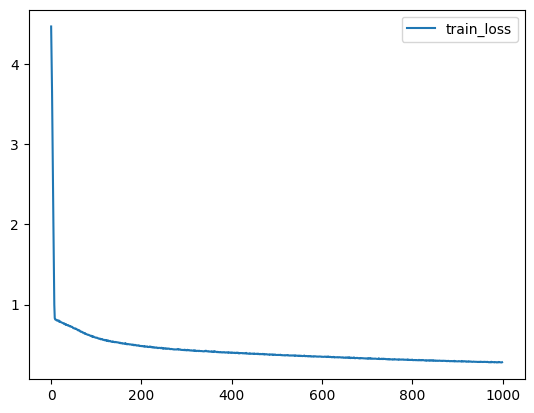

In [50]:
from matplotlib import pyplot as plt
plt.plot(losses, label='train_loss')

plt.legend()
plt.show

In [51]:
# pred_label = []
# true_label = []
# for batch in tqdm(testloader):
#     batch = [i.cuda() for i in batch]
#     sent_id, masks, labels = batch

#     preds = model(sent_id, masks)
#     #pred_label.extend(torch.argmax(preds, axis = 1).cpu())
#     pred_label.extend(preds.cpu())
#     true_label.extend(labels.cpu())

In [52]:
#在上面的代码中，我们首先定义了两个空列表pred_label和true_label来存储
#模型的预测标签和真实标签。然后，我们遍历测试集并对每个批次进行预测
#。将预测值和真实值添加到相应的列表中后，我们可以使用
#sklearn库中的mean_absolute_error函数来计算MAE。
#最后，我们将MAE打印出来。
from sklearn.metrics import mean_absolute_error

# pred_label = []
# true_label = []
pred_label_1 = []
pred_label_2 = []
true_label_1 = []
true_label_2 = []
for batch in tqdm(testloader):
    batch = [i.cuda() for i in batch]
    sent_id, masks, labels = batch

    preds = model(sent_id, masks)
    # pred_label.extend(preds.detach().cpu().numpy())
    # true_label.extend(labels.detach().cpu().numpy())
    pred_label_1.extend(preds[:, 0].detach().cpu().numpy())
    pred_label_2.extend(preds[:, 1].detach().cpu().numpy())
    true_label_1.extend(labels[:, 0].detach().cpu().numpy())
    true_label_2.extend(labels[:, 1].detach().cpu().numpy())

# mae = mean_absolute_error(true_label, pred_label)
mae_1 = mean_absolute_error(true_label_1, pred_label_1)
mae_2 = mean_absolute_error(true_label_2, pred_label_2)

#print(f'MAE: {mae}')

print(f'MAE for Valence: {mae_1}')
print(f'MAE for Arousal: {mae_2}')
#Ckipall2000,MAE for Valence: 0.9184504151344299,MAE for Arousal: 1.0241398811340332


100%|██████████| 15/15 [00:00<00:00, 62.24it/s]

MAE for Valence: 0.7356104850769043
MAE for Arousal: 0.5654029250144958


In [53]:
# def predict_sentiment(sentence, model, tokenizer):
#     encoded_sent = tokenizer.encode_plus(
#         sentence,
#         truncation=True,
#         max_length=50,
#         add_special_tokens=True,
#         # pad_to_max_length=True,
#         padding='longest',
#         return_attention_mask=True,
#         return_tensors='pt'
#     )
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     input_ids = encoded_sent['input_ids'].to(device)
#     attention_mask = encoded_sent['attention_mask'].to(device)

#     with torch.no_grad():
#         output = model(input_ids, attention_mask)

#     return output.item()

def predict_sentiment(sentence, model, tokenizer):
    encoded_sent = tokenizer.encode_plus(
        sentence,
        truncation=True,
        max_length=50,
        add_special_tokens=True,
        padding='longest',
        return_attention_mask=True,
        return_tensors='pt'
    )
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cuda'if torch.cuda.is_available() else print("gpu error"))
    input_ids = encoded_sent['input_ids'].to(device)
    attention_mask = encoded_sent['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    return output.cpu().numpy()

In [54]:
sentence = "傻逼嗎?"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你害我輸了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "可惡，你害我放槍了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "就等你這張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "不知道要出哪張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你到底會不會打牌"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "難過"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你很討厭"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你老是盯我的牌，讓我很不舒服。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我放槍了，這場遊戲讓我很失望。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "很不友善"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "太可惡了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "讓我多想想呢"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我很高興"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我高興到不行"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "生氣"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))



傻逼嗎? [[0.5452776  0.36652327]]
你害我輸了 [[-1.4215188   1.19612837]]
可惡，你害我放槍了 [[-1.59926128  1.43718719]]
就等你這張 [[1.13570595 0.73045492]]
不知道要出哪張 [[ 0.41880369 -0.1175952 ]]
你到底會不會打牌 [[-0.79097462 -0.96710777]]
難過 [[-1.40833306  0.63496876]]
你很討厭 [[-2.30403447  0.46423244]]
你老是盯我的牌，讓我很不舒服。 [[-0.76188278  0.73773861]]
我放槍了，這場遊戲讓我很失望。 [[-1.07717443  1.49525881]]
很不友善 [[-2.44124365  0.79037714]]
太可惡了 [[-2.00085068  2.28627205]]
讓我多想想呢 [[ 0.27762175 -0.06099081]]
我很高興 [[1.69185925 1.20915365]]
我高興到不行 [[1.35407925 0.96018744]]
生氣 [[-0.51565886 -0.02523565]]


In [56]:
torch.save(model.state_dict(), '../DongModel/BaseAll1000Smooth')
model.load_state_dict(torch.load('../DongModel/BaseAll1000Smooth'))
model.eval()
sentence = "胡屁胡"
score = predict_sentiment(sentence, model, tokenizer)
print(score)

[[6.3459716 6.2083364]]
